## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [38]:
# load in packages
from itertools import combinations
from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
from sklearn.model_selection import train_test_split
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [10]:
# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


## 1. Inspect the data

In [11]:
train_data.shape

(84534, 10)

In [12]:
train_data.dtypes

ID             int64
Promotion     object
purchase       int64
V1             int64
V2           float64
V3           float64
V4             int64
V5             int64
V6             int64
V7             int64
dtype: object

In [13]:
train_data.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,36418.440539,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,1.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31467.250000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,62827.500000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,94438.750000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,126184.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


In [14]:
#checking for missing values
train_data.isnull().sum()

ID           0
Promotion    0
purchase     0
V1           0
V2           0
V3           0
V4           0
V5           0
V6           0
V7           0
dtype: int64

In [15]:
#Create a DF with clients that recieve the promotion

promoted_users = train_data[train_data['Promotion'] == 'Yes']
promoted_users.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2
8,15,Yes,0,2,31.930423,0.393317,2,3,1,2
10,17,Yes,0,1,32.770916,-1.511395,2,1,4,1
12,20,Yes,0,1,36.957009,0.133583,2,3,1,1
14,22,Yes,0,3,36.911714,-0.905350,2,2,4,1


## 2. Distribution of promotion

In [16]:
#Group the data by promotion and purchase 
train_data.groupby(by=['Promotion','purchase'], as_index = False)['ID'].count()

,Promotion,purchase,ID
0,No,0,41851
1,No,1,319
2,Yes,0,41643
3,Yes,1,721


How many clients we have in each group?

In [17]:
train_data['Promotion'].value_counts()

Yes    42364
No     42170
Name: Promotion, dtype: int64

## Analyzing Data

### Invariant metric

We'll check if the invariant metric (Number of participants) doesn't show statistically difference. It means that the number of customers assigned to each group is similar.

It's important to check this as a prerequisite so that the following inferences on the evaluation metrics are founded on solid ground.

$$ H_0: Number-of-participants_{ctrl} - Number of participants_{exp} = 0$$

$$ H_1: Number of participants_{ctrl} - Number of participants_{exp} \not= 0$$

$$ \alpha = 0.05 $$

**Analytical approach:**

In [18]:
#Calculate P-value with and analytical approach

n = train_data['Promotion'].value_counts().sum() #n data points
sd = np.sqrt(0.5 * (1 - 0.5) * n) #calculate standard deviation
z = ((42170 + 0.5) - 0.5 * n) / sd #calculate z
p_value = 2 * stats.norm.cdf(z) #calculate p-value
print('p_value:', p_value)

p_value: 0.5068140685419046


**Bootstraping**

In [19]:
def calculate_diff(df):
    """Calculate the difference between the two groups (Control and Experimental)
    INPUT: df → pandas DataFrame
    Output: invariant metric: difference between groups - int """
    
    return (df.query("Promotion == 'No'").shape[0] - df.query("Promotion == 'Yes'").shape[0])

n_trials = 1000
n_points = train_data.shape[0]
sample_diffs = []
    
# For each trial...
for _ in range(n_trials):
    # draw a random sample from the data with replacement...
    sample = train_data.sample(n_points, replace = True)
    
    # compute the desired metric...
    sample_diff = calculate_diff(sample)
        
    # and add the value to the list of sampled metrics
    sample_diffs.append(sample_diff)
    
# Compute the confidence interval bounds
lower_limit = np.percentile(sample_diffs, (1 - .95)/2 * 100)
upper_limit = np.percentile(sample_diffs, (1 + .95)/2 * 100)

print("Confidence intervals (Type I error rate = 0.05):\n"
     "Lower Limit:", lower_limit,"\n"
     "Upper Limit:", upper_limit)

Confidence intervals (Type I error rate = 0.05):
Lower Limit: -750.0999999999999 
Upper Limit: 334.0


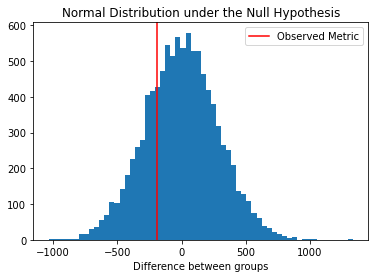

In [20]:
# Difference between groups - distribution of our null hypothesis
null_values = np.random.normal(0, np.std(sample_diffs), 10000)
plt.hist(null_values, bins=60)
plt.title("Normal Distribution under the Null Hypothesis")
plt.axvline(calculate_diff(train_data), color='r', label="Observed Metric")
plt.xlabel('Difference between groups')
plt.legend();

In [21]:
#Calculate P-value
z = (calculate_diff(train_data) - 0) / np.std(sample_diffs)
p_value = 2 * stats.norm.cdf(z)
print("P-value:", p_value)

P-value: 0.494279519194443


We **Fail to reject the null hypothesis**. The difference in the invariant metric isn't statistically significant.

We can continue on to evaluating the evaluation metrics

### Calculate Evaluation Metrics

First we need to calculate the metrics

$$Incremental Response Rate$$

$$IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$

In [22]:
def calculate_irr(dataframe):
    """ Calculate IRR.
    
    INPUT: dataframe = pandas dataframe 
    
    OUTPUT: IRR - float - Incremental Response Rate"""
    
    purch_treat = dataframe.query("Promotion == 'Yes'").query('purchase == 1').shape[0]
    purch_ctrl = dataframe.query("Promotion == 'No'").query('purchase == 1').shape[0]
    cust_treat = dataframe.query("Promotion == 'Yes'").shape[0]
    cust_ctrl = dataframe.query("Promotion == 'No'").shape[0]
    
    IRR = (purch_treat / cust_treat) - (purch_ctrl / cust_ctrl)
    return IRR

In [23]:
#Calculate observed IRR
IRR = calculate_irr(train_data)
print(IRR)

0.009454547819772702


$$Net Incremental Revenue$$

$$ NIR = (10 * purch_{treat} - 0.15 * cust_{treat}) - 10 * purch_{ctrl}$$

In [24]:
def calculate_nir(dataframe):
    """ Calculate NIR.
    
    INPUT: dataframe = pandas dataframe 
    
    OUTPUT: NIR - float - Net Incremental Revenue"""
    
    purch_treat = dataframe.query("Promotion == 'Yes'").query('purchase == 1').shape[0]
    purch_ctrl = dataframe.query("Promotion == 'No'").query('purchase == 1').shape[0]
    cust_treat = dataframe.query("Promotion == 'Yes'").shape[0]
    cust_ctrl = dataframe.query("Promotion == 'No'").shape[0]
    
    NIR = (10 * purch_treat - 0.15 * cust_treat) - 10 * purch_ctrl
    return NIR

In [25]:
#Calculate observed NIR
NIR = calculate_nir(train_data)
print('NIR:', NIR)

NIR: -2334.5999999999995


## Perform a Hypothesis test for the IRR and NIR value

We want to perform a hypothesis test to see if the experiment has shown statistical significance results.

Analysis of statisticaly of $IRR$ and $NIR$ values. It shall determine if the experiment had a positive effect in metrics

For the further hypothesis test we'll use an $\alpha_{overall} = 0.05$, as we are using more than one variable metric, we'll make a correction on the individual Type I Error Rate to maintain the overall rate.

Our alpha with Bonferroni correction:

$$Bonferroni Correction: \frac{\alpha_{overall}}{number-of-metrics} = \frac{0.05}{2} = 0.025$$


### Incremental Response Rate (IRR)

Hypothesis:

$$H_0: IRR = 0$$

$$H_1: IRR > 0$$

We'll apply bootstraping in our data to estimate the sampling distribution

In [65]:
n_trials = 1000
n_points = train_data.shape[0]
sample_irrs = []
    
# For each trial...
for _ in range(n_trials):
    # draw a random sample from the data with replacement...
    sample = train_data.sample(n_points, replace = True)
    
    # compute the desired metric (IRR)...
    sample_irr = calculate_irr(sample)
        
    # and add the value to the list of sampled IRR
    sample_irrs.append(sample_irr)
    
# Compute the confidence interval bounds
lower_limit = np.percentile(sample_irrs, (1 - .975)/2 * 100)
upper_limit = np.percentile(sample_irrs, (1 + .975)/2 * 100)

print("Confidence intervals (Overall Type I error rate   = 0.025):\n"
     "Lower Limit:", lower_limit,"\n"
     "Upper Limit:", upper_limit)

Confidence intervals (Overall Type I error rate   = 0.025):
Lower Limit: 0.007846647893952428 
Upper Limit: 0.011074628933326353


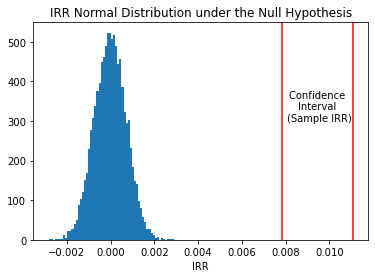

In [66]:
# distribution of our null hypothesis
null_IRRs = np.random.normal(0, np.std(sample_irrs), 10000)
plt.hist(null_IRRs, bins=60)
plt.title("IRR Normal Distribution under the Null Hypothesis")
plt.xlabel('IRR')
plt.axvline(lower_limit, color='r')
plt.axvline(upper_limit, color='r')
plt.text(lower_limit+0.0002, 300, 'Confidence \nInterval \n(Sample IRR)', ma='center');

In [68]:
#Calculate P-value
p_value = 1 - stats.norm.cdf(IRR, 0, np.std(sample_irrs))
print('P-Value:', p_value)

P-Value: 0.0


### IRR conclusions

The P-value is below our $\alpha$, so we **reject the null hypothesis**. 

It means that the experiment has shown statistically significant results for the IRR metric.

Now we'll analyze the other variable metric: INN

### Net Incremental Reveneu (NIR)

Hypothesis:

$$H_0: NIR \le 0$$



$$H_1: NIR > 0$$

We'll apply bootstraping in our data to estimate the sampling distribution

In [29]:
n_trials = 1000
n_points = train_data.shape[0]
sample_nirs = []
    
# For each trial...
for _ in range(n_trials):
    # draw a random sample from the data with replacement...
    sample = train_data.sample(n_points, replace = True)
    
    # compute the desired metric (NIR)...
    sample_nir = calculate_nir(sample)
        
    # and add the value to the list of sampled NIR
    sample_nirs.append(sample_nir)
    
#Compute the confidence interval bounds
lower_limit = np.percentile(sample_nirs, (1 - .975)/2 * 100)
upper_limit = np.percentile(sample_nirs, (1 + .975)/2 * 100)

print("Confidence intervals (Type I error rate   = 0.025):\n"
     "Lower Limit:", lower_limit,"\n"
     "Upper Limit:", upper_limit)

Confidence intervals (Type I error rate   = 0.025):
Lower Limit: -3035.940625 
Upper Limit: -1633.2174999999993


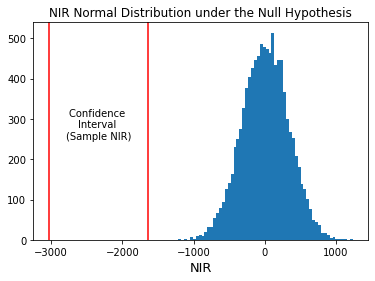

In [30]:
#plot distribution of our null hypothesis
null_NIRs = np.random.normal(0, np.std(sample_nirs), 10000)
plt.hist(null_NIRs, bins=60)
plt.title("NIR Normal Distribution under the Null Hypothesis")
plt.xlabel('NIR', fontsize=13)
plt.axvline(lower_limit, color='r')
plt.axvline(upper_limit, color='r')
plt.text(lower_limit+250, 250, 'Confidence \nInterval \n(Sample NIR)', ma='center');

In [31]:
#Calculate p-value
p_value = 1 - stats.norm.cdf(NIR, 0, np.std(sample_nirs))
print("P-Value:", p_value)

P-Value: 0.9999999999997732


### NIR conclusions

The P-value is well above our $\alpha$, so we **fail to reject the null hypothesis**.

It means that the experiment doesn't shows good results in our NIR metric.

We see before that the promotion actually improves the response rate. Maybe if instead of carrying out the promotional campaign at random, we select the appropriate segment of clients, we could improve our NIR indicator.

We can simulate this scenario by building a model that predicts the users who will show the best response to the promotion and what happens if we target the campaign at them.

## Model Building

The goal of our model is to predict what clients are the best to target in our promotion campaign.

For that we'll try two models:
* Random Forest.
* Easy Ensemble.

In [32]:
#Select features and target variable
X = train_data.drop(columns = ['ID','purchase','Promotion'])
y = train_data['purchase']

In [33]:
#Split the data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .33)

Note: with the models we are using we don't need to scale the data!

In [51]:
def labeling(y):
    promotion_df = []
    for i in y:
        if i == 1:
            promotion_df.append('Yes')
        if i == 0:
            promotion_df.append('No')
            
    return np.asarray(promotion_df)

### Easy Ensemble Classifier

In [52]:
EEC = EasyEnsembleClassifier(sampling_strategy='all', replacement=True)

In [53]:
EEC.fit(X_train, y_train)

EasyEnsembleClassifier(replacement=True, sampling_strategy='all')

In [54]:
y_hat = EEC.predict(X_test)

In [55]:
print("F1-Score:",f1_score(y_test, y_hat, average='weighted'))

F1-Score: 0.68456423140982


In [56]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    y_hat = EEC.predict(df)
    
    promotion = labeling(y_hat)
    
    return promotion

In [57]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0188.

Your nir with this strategy is 362.15.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.01879492986673225, 362.1500000000001)

### Random Forest Classifier

In [58]:
#Instantiete the model
clf = RandomForestClassifier(max_depth=5, random_state=0,class_weight='balanced_subsample')

In [59]:
#Train the model
clf.fit(X = X_train, y = y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=5,
                       random_state=0)

In [60]:
y_hat = clf.predict(X_test)

In [61]:
np.unique(y_hat)

array([0, 1], dtype=int64)

In [62]:
print("F1-Score:",f1_score(y_test, y_hat, average='weighted'))

F1-Score: 0.7556901740437174


In [63]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    y_hat = clf.predict(df)
    
    promotion = labeling(y_hat)
    
    return promotion

In [64]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0195.

Your nir with this strategy is 343.10.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.019525949566677296, 343.10000000000014)

## Conclutions

We can conclude that with a machine learning model to choose clients to target, we can improve the NIR metric.

It went from a negative value to a positive one, it means that the promotion brings earnings to the company.

Anyway, here we worked with a very unbalanced data set. I think we could improve even more the performance if we count with better data.